In [1]:
# Math
import math
import torch

# Data Processing
import numpy as np
from numpy import genfromtxt
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

## Settings

In [2]:
classical_features_path = 'C:\\Users\\alext\\Desktop\\School\\2021 Spring\\CS 271\\Final Project\\Feature Extraction\\Classical\\Classical Features.csv'
jazz_features_path = 'C:\\Users\\alext\\Desktop\\School\\2021 Spring\\CS 271\\Final Project\\Feature Extraction\\Jazz\\Jazz Features.csv'
roc_export_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Classification\PCA ROC Data.csv'

# The number of principle components
num_pc = 22

# Set the plot font
font = {'family' : 'DejaVu Sans',
        'size'   : 18}

matplotlib.rc('font', **font)

## Utility Functions

In [3]:
# Returns the mean of each row
def row_mean(tensor):
    return list(map(torch.mean, tensor))

# Subtracts a vector from each column of a matrix
def sub_vec(tensor, vec):
    return torch.vstack(list(map(torch.subtract, tensor, vec)))

## Custom PCA Model

In [4]:
class PCA_model:
    def __init__(self, training_data, num_components):
        mu, eigenbasis, scoring_mat = self.gen_model(training_data, num_components)
        
        self.mu = mu
        self.eigenbasis = eigenbasis
        self.scoring_mat = scoring_mat
    
    
    # Generates a model using the given training data
    # Computes the row mean of the data, the eigenbasis, and scoring matrix
    def gen_model(self, training_data, num_components):
        # Calculate the mean of each row (measurement type)
        mu = row_mean(training_data)
        # Normalize the training data by subtracting the mean from each row
        A = sub_vec(training_data, mu)
        
        # Perform the svd technique on the normalized training data
        # U contains the eigenvectors of A A^T
        # S contains the corresponding eigenvalues
        # Note that the eigenvectors and eigenvalues are already ordered
        (U, S, V) = torch.svd(A)
        
        # In this model, we don't select by weight
        l = num_components

        # Select the l largest eigenvectors in U to form our eigenbasis
        U_prime = U[:, 0:l]

        # Compute and print the eigenvalues of C
        num_samples = A.size()[1]
        eigenvalues = (S[:l]**2)/num_samples

        # Transpose the eigenbasis
        U_prime_t = torch.transpose(U_prime,0,1)
        # Perform a matrix multiplicaiton on the eigenbasis and
        # normalized training data to get the scoring matrix
        scoring_mat = U_prime_t @ A
        
        return mu, U_prime_t, scoring_mat
    
    
    # Returns the minimum distance between a vector and any column of a matrix
    def min_dist_vec(vector, matrix):
        # Get the size of the matrix
        matrix_rows = matrix.size()[0]
        matrix_cols = matrix.size()[1]
        
        min_dist_sq = float('inf')

        # Find the minimum distance between the vector and each matrix column
        for matrix_col in range(matrix_cols):
            # Select the scoring column
            mat_col_vec = matrix[:, matrix_col:matrix_col+1]

            # Calculate the distance squared
            diff = vector - mat_col_vec
            dist_sq = torch.sum(torch.square(diff), dim=0)
            
            # Upade the minimum
            if dist_sq < min_dist_sq:
                min_dist_sq = dist_sq
        
        # Return the minimum distance
        return math.sqrt(min_dist_sq)
    
    
    # Score a matrix of samples against the model
    def score(self, samples):
        # Normalize the sample data by subtracting the training data mean from each row
        Y_prime = sub_vec(samples, self.mu)
        
        # Project the sample data into the eigenbasis to find the weight vectors
        W = self.eigenbasis @ Y_prime
        
        # Get the number of data samples
        weight_cols = W.size()[1]
        
        # A list of scores for each weight vector
        scores = []

        # Calculate the score for each weight vector
        for weight_col in range (weight_cols):
            # Select weight column
            weight_vec = W[:, weight_col:weight_col+1]
            
            # Save the minimum score of each weight vector
            min_dist = PCA_model.min_dist_vec(weight_vec, self.scoring_mat)
            scores.append(min_dist)

        return scores

## Load the Feature Data

In [5]:
def load_samples(group1_path, group2_path, num_train, num_clasif):
    num_to_load = num_train + num_clasif
    
    # Load enough features for training and classification
    group1_features = genfromtxt(group1_path, delimiter=',', max_rows=num_to_load)
    group2_features = genfromtxt(group2_path, delimiter=',', max_rows=num_to_load)
    
    # Get the training features from both groups
    training_X = group1_features[0:num_train, :]
    training_Y = group2_features[0:num_train, :]
    training_samples = np.concatenate((training_X, training_Y), axis=0)
    
    # Get the testing features from both groups
    testing_X = group1_features[num_train:num_to_load, :]
    testing_Y = group2_features[num_train:num_to_load, :]
    testing_samples = np.concatenate((testing_X, testing_Y), axis=0)
    
    # Get the classifications for the training and testing feature sets
    training_classifs = ([0] * num_train) + ([1] * num_train)
    testing_classifs = ([0] * num_clasif) + ([1] * num_clasif)
    
    return (training_samples, training_classifs, testing_samples, testing_classifs)

## Normalize Feature Sets

In [6]:
def normalize_features(training_samples, testing_samples):
    # Compute the mean and varience of each feature in the training set
    scaler = StandardScaler().fit(training_samples)

    # Normalize both the training and testing feature sets
    training_samples = scaler.transform(training_samples)
    testing_samples = scaler.transform(testing_samples)
    
    return (training_samples, testing_samples)

## Compute the Accuracy

In [7]:
def compute_accuracy(classical_scores, jazz_scores):
    num_samples = len(classical_scores)
    num_correct = 0

    for sample in range(num_samples):
        if classical_scores[sample] < jazz_scores[sample]:
            prediction = 0
        else:
            prediction = 1

        if prediction == testing_classifs[sample]:
            num_correct += 1

    accuracy = (num_correct / num_samples)
    return accuracy

## Normalize PCA Scores

In [8]:
# Code from https://stackoverflow.com/questions/1969240/mapping-a-range-of-values-to-another
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [9]:
def normalize_scores(classical_scores, jazz_scores):
    num_samples = len(classical_scores)
    
    # Contains probabilities of a song being in either genre they add to 1)
    norm_scores = np.zeros(shape=(num_samples, 2))
    
    # Find the range of scores
    min_score = min(min(classical_scores), min(jazz_scores))
    max_score = max(max(classical_scores), max(jazz_scores))
    
    # Normalize the probabilities
    for sample in range(num_samples):
        # Map the scores to a range 0-1
        classical_norm = translate(classical_scores[sample], min_score, max_score, 0, 1)
        jazz_norm = translate(jazz_scores[sample], min_score, max_score, 0, 1)
        
        # Invert the scores so that larger is better
        classical_norm = 1 - classical_norm
        jazz_norm = 1 - jazz_norm
        
        # Normazie the scores so that they add up to 1
        magnitude = math.sqrt(classical_norm * classical_norm + jazz_norm * jazz_norm)
        classical_norm /= magnitude
        jazz_norm /= magnitude
        
        # Add the scores to the list
        norm_scores[sample] = [classical_norm, jazz_norm]
    
    return norm_scores

## Plot Accuracies

In [10]:
def plot_accuracies(variables, accuracies, variable_name, title_name):
    # Set the plot size
    figure(figsize=(8, 6), dpi=80)
    
    # Plot the data
    plot.plot(variables, accuracies, marker='.', markersize=15)
    
    # Set the titles
    plot.title(title_name)
    plot.xlabel(variable_name)
    plot.ylabel('Accuracy')
    
    # Force the x-axis to display integer ticks
    ax = plot.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plot.show()

## Load a Small Feature Set

In [11]:
# Load the feature data
sample_data = load_samples(classical_features_path, jazz_features_path, 6000, 2400)
training_samples  = sample_data[0]
training_classifs = sample_data[1]
testing_samples   = sample_data[2]
testing_classifs  = sample_data[3]

# Normalize the feature sets
(training_samples, testing_samples) = normalize_features(training_samples, testing_samples)

# Convert the numpy matrices into pytorch tensors
classical_training = torch.tensor(training_samples[0:6000])
jazz_training = torch.tensor(training_samples[6000:12000])
testing_samples = torch.tensor(testing_samples)

# Transpose the matrices so that each data vector is a column
classical_training = torch.transpose(classical_training, 0, 1)
jazz_training = torch.transpose(jazz_training, 0, 1)
testing_samples = torch.transpose(testing_samples, 0, 1)

## Principle Component Testing

In [12]:
# Train a model on each genre
print('Training... ', end = '')
classical_model = PCA_model(classical_training, num_pc)
jazz_model = PCA_model(jazz_training, num_pc)
print('done')

# Score the testing samples against each model
print('\nScoring... ', end = '')
classical_scores = classical_model.score(testing_samples)
jazz_scores = jazz_model.score(testing_samples)
print('done')

# Compute the accuracy
print('\nTesting Accuracy... ', end = '')
accuracy = compute_accuracy(classical_scores, jazz_scores)
print('done')
print('Accuracy: {}'.format(accuracy * 100))

Training... done

Scoring... done

Testing Accuracy... done
Accuracy: 74.20833333333333


## Plotting the ROC Curve

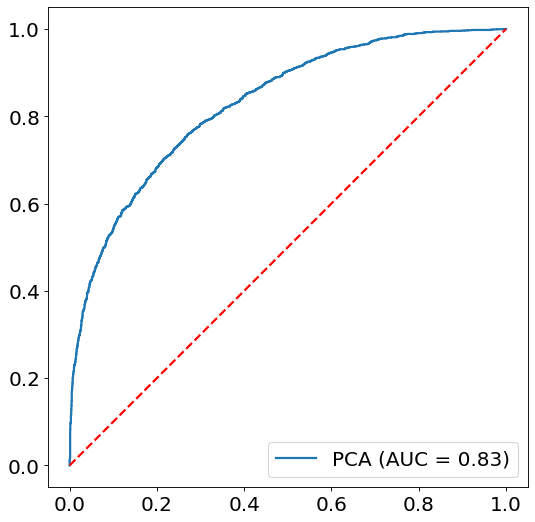

In [13]:
# Normalize the scores
norm_scores = normalize_scores(classical_scores, jazz_scores)

fpr, tpr, threshold = roc_curve(testing_classifs, norm_scores[:, 1])
roc_auc = auc(fpr, tpr)

# Set the plot size
fig = figure(figsize=(6, 6), dpi=80)
ax = fig.add_axes([0,0,1,1])

# Plot the ROC
plot.plot(fpr, tpr, lw=2, label='PCA (AUC = %0.2f)' % roc_auc)

# Draw the middle line
plot.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

plot.legend(loc='lower right')
plot.show()

## Export FPR and TPR

In [14]:
print('Exporting ROC Data...')

f = open(roc_export_path, "w")

for item in range(fpr.shape[0]):
    f.write(str(fpr[item]) + ',' + str(tpr[item]) + '\n')

f.close()

print('Finished')

Exporting ROC Data...
Finished
